# Create the dataset required for SLICE

## Unpack the polygons for France data

In [5]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon

path_gpkg = "./france/PARCELLES_GRAPHIQUES.gpkg"

# Load the data
data = gpd.read_file(path_gpkg)

## Sample Polygons to create the dataset

### Choice 1: Randomly sample points from the data
**Warning**: This method will require almost the whole france planet mosiacs which could end up in TBs

In [ ]:
"""
points = data.sample(10000)
"""

### Choice 2: Select points from an ROI that has diverse plots
Randomly select 10000 points from data and save them to data/france/points.gpkg

In [ ]:
# ROI of sampled points precise repetability
roi = Polygon([
            [-0.7155534667066932, 43.39057963239615],
            [-0.7155534667066932, 43.156608691390645],
            [0.34359722909410806, 43.156608691390645],
            [0.34359722909410806, 43.39057963239615]
])
 
data = data[data.within(roi)]
sampled = data.sample(10000)

# Save the sampled points for training and testing
sampled.to_file("data/france/sampled.gpkg", driver="GPKG")

## Visualize Data

<Axes: >

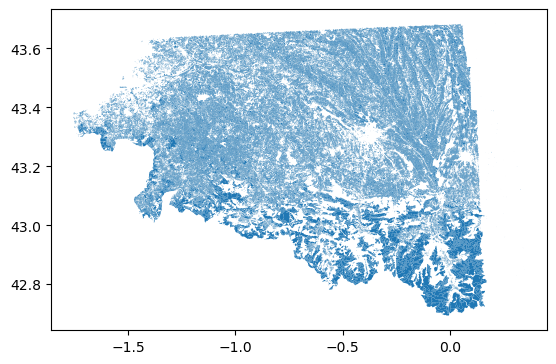

In [50]:
data.plot()

<Axes: >

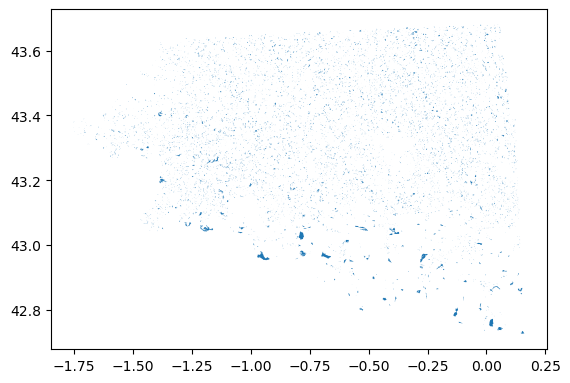

In [72]:
sampled.plot()

<Axes: >

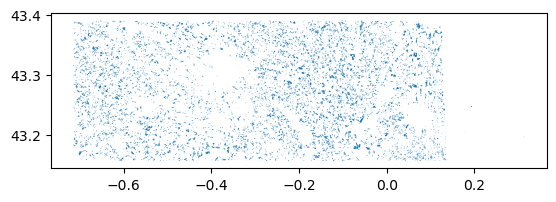

In [3]:
sampled.plot()

## Extract images

In [161]:
import os
import shutil
import cv2
import numpy as np
import geopandas as gpd
import tensorflow as tf
from pyunpack import Archive
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

BASE_DIR = "france/"

path = BASE_DIR + "gz_files/"
tf_out_path = BASE_DIR + "tf_files/"

if os.path.exists(tf_out_path):
    print("Removing Existing Directory.....")
    shutil.rmtree(tf_out_path)

print("Creating TFRECORD Exctract Directory.....")
os.makedirs(tf_out_path)
    
gz_files = os.listdir(path)
gz_files = [f for f in gz_files if f.endswith('.gz')]

for i in gz_files:
    Archive(path+i).extractall(tf_out_path)

print(">>>>>>>>>> Extraction Complete <<<<<<<<<<<<")
    
img_out_path = BASE_DIR + "images/"
if os.path.exists(img_out_path):
    print("Removing Existing Image Directory.....")
    shutil.rmtree(img_out_path)

print("Creating IMAGE Exctract Directory.....")
os.makedirs(img_out_path)

tf_files = [tf_out_path + f for f in os.listdir(tf_out_path)]

Removing Existing Directory.....
Creating TFRECORD Exctract Directory.....
>>>>>>>>>> Extraction Complete <<<<<<<<<<<<
Removing Existing Image Directory.....
Creating IMAGE Exctract Directory.....


In [162]:
# Create a new geo dataframe
df = gpd.GeoDataFrame()
df['parcel_id'] = None
df['geometry'] = None

options = tf.compat.v1.python_io.TFRecordOptions(tf.compat.v1.python_io.TFRecordCompressionType.NONE)
idx = 0
satellite_features = ['B1', 'B2', 'B3']

for tf_file in tf_files:
    print("Processing File: ", tf_file)
    for example in tf.compat.v1.python_io.tf_record_iterator(tf_file, options=options):
        ex = tf.train.Example.FromString(example)
        min_lon = min(ex.features.feature['longitude'].float_list.value) 
        max_lon = max(ex.features.feature['longitude'].float_list.value) 
        min_lat = min(ex.features.feature['latitude'].float_list.value) 
        max_lat = max(ex.features.feature['latitude'].float_list.value)

        # If any of the coordinates are zero take the second min/max
        if min_lon == 0:
            min_lon = list(set(sorted(ex.features.feature['longitude'].float_list.value)))[1]
        if max_lon == 0:
            max_lon = list(set(sorted(ex.features.feature['longitude'].float_list.value)))[-2]
        if min_lat == 0:
            min_lat = list(set(sorted(ex.features.feature['latitude'].float_list.value)))[1]
        if max_lat == 0:
            max_lat = list(set(sorted(ex.features.feature['latitude'].float_list.value)))[-2]


        geometry = Polygon([
            [min_lon, min_lat],
            [min_lon, max_lat],
            [max_lon, max_lat],
            [max_lon, min_lat]
        ])

        # Calculate the area
        # if geometry.area > 1:
        #     continue


        features = []
        for satellite_feature in satellite_features:
            feature = (ex.features.feature[satellite_feature].float_list.value)
            feature = np.array(feature)
            feature = feature.reshape((224, 224, 1))
            # feature = np.flip(feature, axis=0)
            features.append(feature)
            
        image = np.concatenate(features, axis=2)
        # image = image/np.max(image) # Normalization
        # But using 2188 has more clarity
        image = image/2188

        # Save the image
        image_name = img_out_path + str(idx) + ".png"
        
        cv2.imwrite(image_name, image*255)

        # Save the geo data
        df.loc[idx, 'parcel_id'] = str(idx)
        df.loc[idx, 'geometry'] = geometry
        
        idx += 1

# df.to_file(img_out_path + "geo_data.geojson", driver="GeoJSON")

Processing File:  france/tf_files/ps_france_21-00001.tfrecord
Processing File:  france/tf_files/ps_france_21-00000.tfrecord
Processing File:  france/tf_files/ps_france_21-00006.tfrecord
Processing File:  france/tf_files/ps_france_21-00007.tfrecord
Processing File:  france/tf_files/ps_france_21-00011.tfrecord
Processing File:  france/tf_files/ps_france_21-00010.tfrecord
Processing File:  france/tf_files/ps_france_21-00002.tfrecord
Processing File:  france/tf_files/ps_france_21-00003.tfrecord
Processing File:  france/tf_files/ps_france_21-00008.tfrecord
Processing File:  france/tf_files/ps_france_21-00009.tfrecord
Processing File:  france/tf_files/ps_france_21-00015.tfrecord
Processing File:  france/tf_files/ps_france_21-00014.tfrecord
Processing File:  france/tf_files/ps_france_21-00012.tfrecord
Processing File:  france/tf_files/ps_france_21-00013.tfrecord
Processing File:  france/tf_files/ps_france_21-00005.tfrecord
Processing File:  france/tf_files/ps_france_21-00004.tfrecord


In [163]:
df

,parcel_id,geometry
0,0,"POLYGON ((-0.08773 43.38996, -0.08773 43.39056..."
1,1,"POLYGON ((-0.08170 43.38996, -0.08170 43.39056..."
2,2,"POLYGON ((-0.07566 43.38996, -0.07566 43.39056..."
3,3,"POLYGON ((-0.06962 43.38996, -0.06962 43.39056..."
4,4,"POLYGON ((-0.06359 43.38996, -0.06359 43.39056..."
...,...,...
1659,1659,"POLYGON ((0.28050 43.37371, 0.28050 43.37972, ..."
1660,1660,"POLYGON ((0.28654 43.37371, 0.28654 43.37972, ..."
1661,1661,"POLYGON ((0.29258 43.37371, 0.29258 43.37972, ..."
1662,1662,"POLYGON ((0.29861 43.37371, 0.29861 43.37972, ..."


In [5]:
path_gpkg = "./france/refined.gpkg"

# Load the data
data = gpd.read_file(path_gpkg)
data = data[data.within(roi)]

In [233]:
from shapely.geometry import MultiPolygon
def to_polygons(geometries):
    for geometry in geometries:
        if isinstance(geometry, Polygon):
            yield geometry
        else:
            yield from geometry

dfx = df.copy()

In [322]:
# Calculate the centroid of data
data['centroid'] = data['geometry'].centroid
dfx['parcels'] = None

# Iterate over the data
for idx, row in dfx.iterrows():
    # Get the centroids that lie inside the row's geometry
    idx += 1
    if idx % 50 == 0:
        print("Processing: ", idx)
    centroids = data[data['centroid'].within(row['geometry'])].copy()
    # Drop all columns except the geometry
    centroids = centroids.drop(columns=['centroid', 'ct'])
    # save to geojson
    centroids.to_file(img_out_path + row['parcel_id'] + ".geojson", driver="GeoJSON")

# dfx

Processing:  50
Processing:  100
Processing:  150
Processing:  200
Processing:  250
Processing:  300
Processing:  350
Processing:  400
Processing:  450
Processing:  500
Processing:  550
Processing:  600
Processing:  650
Processing:  700
Processing:  750
Processing:  800
Processing:  850
Processing:  900
Processing:  950
Processing:  1000
Processing:  1050
Processing:  1100
Processing:  1150
Processing:  1200
Processing:  1250
Processing:  1300
Processing:  1350
Processing:  1400
Processing:  1450
Processing:  1500
Processing:  1550
Processing:  1600
Processing:  1650


In [330]:
def draw(img, data_in_dfx, dfx):
    # Get the image of the parcel

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Vertical flip the image using cv2
    # img = cv2.flip(img, 0)

    # Get the coordinates of the parcel
    coords = dfx.geometry.exterior.coords.xy

    # Map the lat/lons to the image

    # Get the min/max lat/lon
    min_lon = min(coords[0])
    max_lon = max(coords[0])
    min_lat = min(coords[1])
    max_lat = max(coords[1])

    # Get the width and height of the image
    img_height, img_width, _ = img.shape

    # Get the width and height of the parcel
    width = max_lon - min_lon
    height = max_lat - min_lat

    # Get the pixel width and height
    pixel_width = img_width/width
    pixel_height = img_height/height


    # Draw the multipolygon in the data_in_dfx
    for i in range(len(data_in_dfx)):
        coords = data_in_dfx.iloc[i].geometry[0].exterior.coords.xy
        
        # Get the pixel coords
        pixel_coords = []
        for i in range(len(coords[0])):
            x = coords[0][i]
            y = coords[1][i]

            # Get the pixel x and y
            pixel_x = (x - min_lon) * pixel_width
            pixel_y = (max_lat - y) * pixel_height

            pixel_coords.append([pixel_x, pixel_y])

        # Convert the pixel coords to int
        pixel_coords = np.array(pixel_coords, dtype=np.int32)
        
        # Draw the polygon
        cv2.polylines(img, [pixel_coords], True, (0, 255, 0), 2)

    # Show the image
    plt.imshow(img)
    # data_in_dfx.plot()

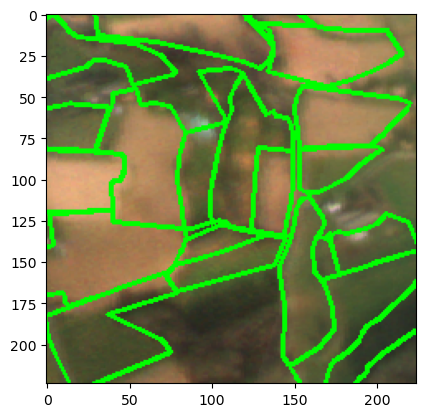

In [333]:
idx = 602
dfx = df.iloc[idx]
data_in_dfx = gpd.read_file(img_out_path + str(idx) + ".geojson")

img = cv2.imread(img_out_path + str(idx) + ".png")
draw(img, data_in_dfx, dfx)
